# **PLS (Partial Least Square)를 이용한 Odor 분석**

---

In [ ]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
package_version(R.version)

[1] ‘4.1.0’


In [ ]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [ ]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("pls")                       # pls
# install.packages("caret")         
# install.packages("mice")        # M.I 결측치 대체
# install.packages("stringr")
# install.packages("devtools")
# install.packages("lmtest")      # Durbin-Watson test (잔차의 독립성)
# install.packages("glmnet")      # Ridge, Lasoo and Elastic Net
# install.packages("Boruta")
# install.packages("car")         # 다중공선성
# install.packages("Metrics")     # RMSE, MAPE
# install.packages("DAAG")        # CV lm

library(DAAG)
library(Metrics)
library(car)
library(Boruta)
library(glmnet)
library(lmtest)
library(devtools)
library(mice)
library(stringr)
library(corrplot)
library(PerformanceAnalytics)
library(pls)
library(caret)

**plsVarSel은  R version 4.0.5에서 지원하지 않으므로, Version을 지정해 다운해야된다.**

In [ ]:
%%R
# install_version("plsVarSel", version = "0.9.6", repos = "http://cran.us.r-project.org")    # VIP
library(plsVarSel)

## **1. Data Preparation**

### **1) Read preprocessed data (log_odo)**

In [ ]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Log + Scaling
log_odo <- as.data.frame(scale(log(odo), center = T, scale = T))
head(log_odo)

          ou       nh3        h2s       mm.1        dms        aca        ppa
1 -1.2249600 -2.043309 -0.3600950 -0.6331603  1.4587731 -1.0749493 -1.4207491
2 -1.2249600 -1.936882  0.3387812  1.0552224  2.8066385  0.7668098  0.9990535
3 -0.8209050 -1.468885 -0.7936594 -0.8879723  2.0631026  0.5917261  0.7867864
4  0.7260806 -1.416330  0.4345010 -0.8879723  1.4646004  0.4284440  0.6354347
5 -1.1919213 -1.263970  0.3446961 -0.8879723 -0.7092863  0.3237269  0.5183596
6 -0.4168700 -1.458160 -1.1504747 -0.8879723 -0.7092863  0.2447109  0.3430590
         iba        bta        iva        vla          ph         pc
1 -1.7334805 -1.6740815 -1.8596790 -1.3374486 -0.64265976 -4.7612230
2  1.2984638  1.1289898  1.3516990  1.2950587  1.08960883  0.8397641
3  0.9772720  1.0331016  1.0695726  1.1290003  0.55236433  0.3658753
4  0.6718374  0.9381735  0.8924571  0.7198563  0.19073125  0.2936154
5  0.5326620  0.7975387  0.8428153  0.6331179  0.21571194  0.3888851
6  0.3998548  0.8066882  0.6910340  0.60

### **2) Data Visualizations**

#### **- 반응변수 (y)**

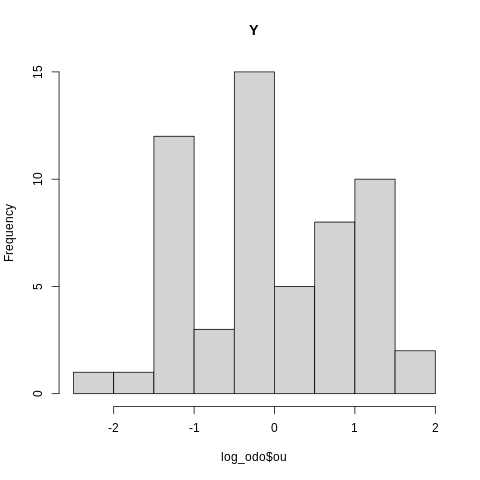

In [ ]:
%%R

hist(log_odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

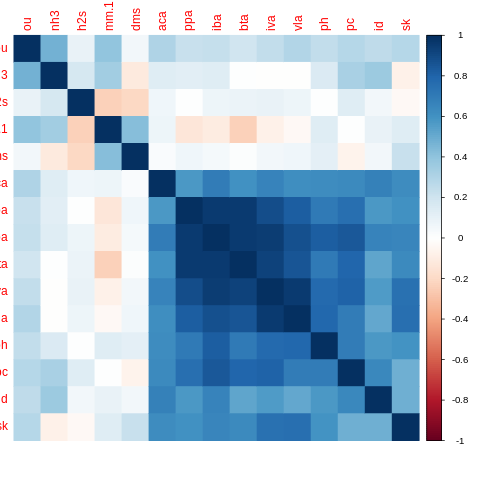

In [ ]:
%%R

log_res <- cor(log_odo, method = "pearson")
corrplot::corrplot(log_res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

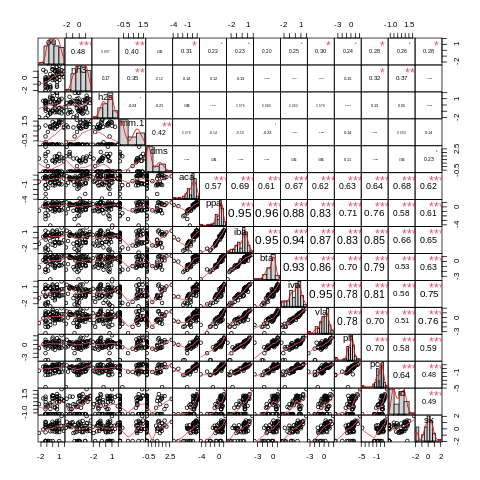

In [ ]:
%%R

chart.Correlation(log_odo, histogram = T, pch = 5)

#### **- Correlation Values**

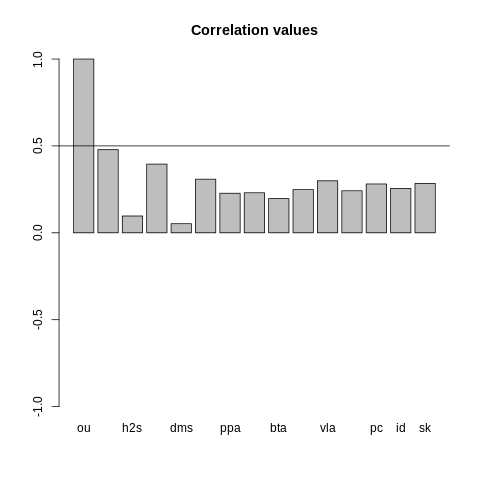

In [ ]:
%%R

# 반응변수
barplot(log_res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(log_res)

### **3) 다중 공선성 확인**

In [ ]:
%%R

log_mr <- lm(ou ~ ., data = log_odo)

log_VIF <- vif(log_mr)
print(log_VIF)

      nh3       h2s      mm.1       dms       aca       ppa       iba       bta 
 2.590253  1.394278  2.592621  1.538076  2.940215 31.452120 71.838164 33.268410 
      iva       vla        ph        pc        id        sk 
52.146947 19.397979  6.730872  6.965551  3.131767  3.521264 



 5 개 : aca ppa iba bta iva

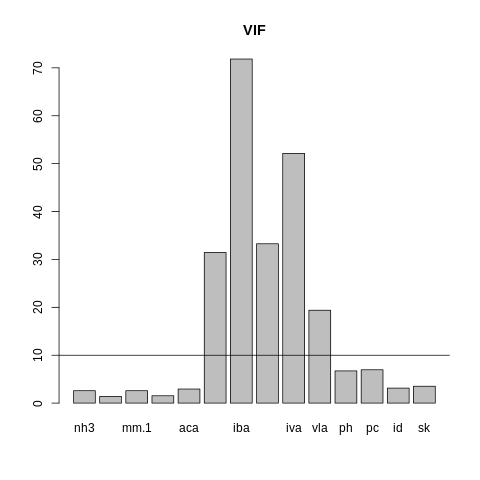

In [ ]:
%%R

barplot(log_VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(log_VIF > 10), "개 :", names(odo[log_VIF > 10]))

## **2. Variables Selection**

- Ridge Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}\beta_j^2$

- Lasso Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}|\beta_j|$

- Elastic Net Reg　:　RSS($\beta$)　+　$\lambda_1 \sum_{j=1}^{p}\beta_j^2　+　\lambda_2 \sum_{j=1}^{p}|\beta_j|$

\
- glmnet　:　 RSS($\beta$)　+　$\lambda[(1-\alpha) \sum_{j=1}^{p}\beta_j^2　+　\alpha \sum_{j=1}^{p}|\beta_j|]$

  - $\alpha=1$ : Lasso
  - $\alpha=0$ : Ridge
  - $0<\alpha<1$ : Elastic Net

### **1) Ridge (odor)**

- threshold = 0.05

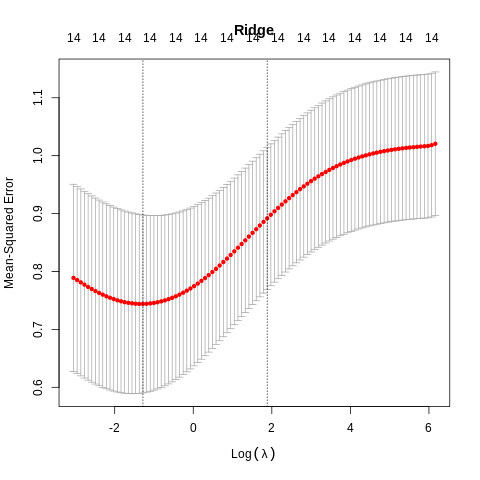

In [ ]:
%%R

y <- log_odo$ou
x <- as.matrix(subset(log_odo, select = -c(ou)))

cv_ridge <- cv.glmnet(x, y, alpha = 0, parallel = TRUE, standardize = T, type.measure = "mse")

plot(cv_ridge, main = "Ridge")

In [ ]:
%%R

print(cv_ridge)


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", parallel = TRUE,      alpha = 0, standardize = T) 

Measure: Mean-Squared Error 

    Lambda Index Measure     SE Nonzero
min  0.278    81  0.7439 0.1536      14
1se  6.568    47  0.8918 0.1227      14


In [ ]:
%%R

# Ridge로 구한 회귀 계수
ri_coef <- round(as.matrix(coef(cv_ridge, s = cv_ridge$lambda.min)), 2)
ri_coef

                1
(Intercept)  0.00
nh3          0.32
h2s          0.07
mm.1         0.25
dms         -0.03
aca          0.11
ppa          0.03
iba         -0.05
bta          0.05
iva          0.03
vla          0.16
ph          -0.07
pc          -0.02
id          -0.05
sk           0.10


In [ ]:
%%R

# Threshold = 0.05보다 작은 값의 변수는 제거
th <- 0.05

rit_coef <- ri_coef[abs(ri_coef[, 1]) > th, ]
cat("선택된 변수 : ", names(rit_coef), "(", length(rit_coef), "개)", "\n")

del_rit_coef <- ri_coef[abs(ri_coef[, 1]) <= th, ]
cat("제거된 변수 : ", names(del_rit_coef))

선택된 변수 :  nh3 h2s mm.1 aca vla ph sk ( 7 개) 
제거된 변수 :  (Intercept) dms ppa iba bta iva pc id

In [ ]:
%%R

odor <- cbind(log_odo["ou"], log_odo[names(rit_coef)[2:length(rit_coef)]])
head(odor)

          ou        h2s       mm.1        aca        vla          ph        sk
1 -1.2249600 -0.3600950 -0.6331603 -1.0749493 -1.3374486 -0.64265976 0.1754534
2 -1.2249600  0.3387812  1.0552224  0.7668098  1.2950587  1.08960883 1.1256139
3 -0.8209050 -0.7936594 -0.8879723  0.5917261  1.1290003  0.55236433 0.3798852
4  0.7260806  0.4345010 -0.8879723  0.4284440  0.7198563  0.19073125 0.8561538
5 -1.1919213  0.3446961 -0.8879723  0.3237269  0.6331179  0.21571194 0.6289272
6 -0.4168700 -1.1504747 -0.8879723  0.2447109  0.6049416  0.03506233 0.4819419


### **2) LASSO (odol)**

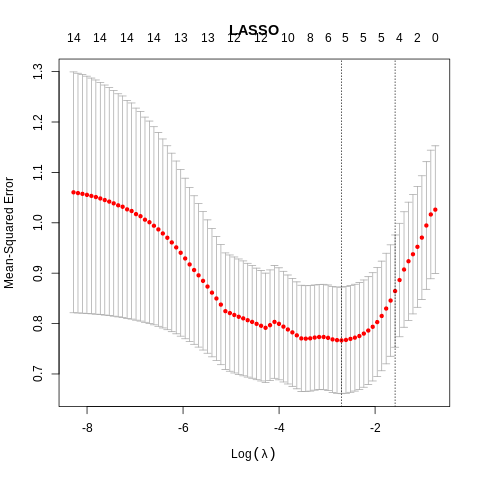

In [ ]:
%%R

y <- log_odo$ou
x <- as.matrix(subset(log_odo, select = -c(ou)))

cv_lasso <- cv.glmnet(x, y, alpha = 1, parallel = TRUE, standardize = T, type.measure = "mse")

plot(cv_lasso, main = "LASSO")

In [ ]:
%%R

print(cv_lasso)


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", parallel = TRUE,      alpha = 1, standardize = T) 

Measure: Mean-Squared Error 

     Lambda Index Measure     SE Nonzero
min 0.06722    22  0.7666 0.1057       6
1se 0.20528    10  0.8645 0.1114       4


In [ ]:
%%R

# LASSO로 구한 회귀 계수
la_coef <- round(as.matrix(coef(cv_lasso, s = cv_lasso$lambda.min)), 2)

la_coef

               1
(Intercept) 0.00
nh3         0.34
h2s         0.01
mm.1        0.21
dms         0.00
aca         0.03
ppa         0.00
iba         0.00
bta         0.00
iva         0.00
vla         0.17
ph          0.00
pc          0.00
id          0.00
sk          0.06


In [ ]:
%%R

lat_coef <- la_coef[la_coef[, 1] != 0, ]
cat("선택된 변수 : ", names(lat_coef), "(", length(lat_coef), "개)", "\n")

del_lat_coef <- la_coef[la_coef[, 1] == 0, ]
cat("제거된 변수 : ", names(del_lat_coef))

선택된 변수 :  nh3 h2s mm.1 aca vla sk ( 6 개) 
제거된 변수 :  (Intercept) dms ppa iba bta iva ph pc id

In [ ]:
%%R

odol <- cbind(log_odo["ou"], log_odo[rownames(la_coef)[la_coef > 0][-1]])
head(odol)

          ou        h2s       mm.1        aca        vla        sk
1 -1.2249600 -0.3600950 -0.6331603 -1.0749493 -1.3374486 0.1754534
2 -1.2249600  0.3387812  1.0552224  0.7668098  1.2950587 1.1256139
3 -0.8209050 -0.7936594 -0.8879723  0.5917261  1.1290003 0.3798852
4  0.7260806  0.4345010 -0.8879723  0.4284440  0.7198563 0.8561538
5 -1.1919213  0.3446961 -0.8879723  0.3237269  0.6331179 0.6289272
6 -0.4168700 -1.1504747 -0.8879723  0.2447109  0.6049416 0.4819419


### **3) Elastic Net (odoe)**

- threshold = 0.0001

In [ ]:
%%R 

# elst.Grid <- expand.grid(.alpha = seq(0.01, 1, 0.01),
#                          .lambda = seq(0.01, 1, 0.01))

# best 결과
elst.Grid <- expand.grid(.alpha = seq(0.001, 0.05, 0.01),
                         .lambda = seq(0.1, 1, 0.1))
head(elst.Grid)

  .alpha .lambda
1  0.001     0.1
2  0.011     0.1
3  0.021     0.1
4  0.031     0.1
5  0.041     0.1
6  0.001     0.2


In [ ]:
%%R

controlObject <- trainControl(
    method = "repeatedcv",
    repeats = 1,
    number = 5
)

In [ ]:
%%R 

elst.Model <- train(
    ou ~.,
    data = log_odo,
    method = 'glmnet',
    tuneGrid = elst.Grid,
    preProc = c('center',"scale"),
    metric = 'MSE',
    trControl = controlObject
)


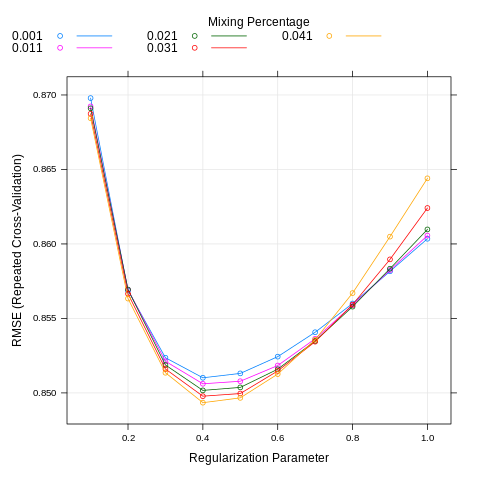

In [ ]:
%%R 

plot(elst.Model)

In [ ]:
%%R

best <- as.numeric(rownames(elst.Model$bestTune))
elst.Model$bestTune
elst.Model$results$Rsquared[best]

[1] 0.3220564


In [ ]:
%%R

# Elastic Net으로 구한 회귀계수
ebb <- elst.Model$finalModel$beta[,best]
round(ebb, 4)

    nh3     h2s    mm.1     dms     aca     ppa     iba     bta     iva     vla 
 0.3303  0.0603  0.2505 -0.0177  0.1040  0.0044 -0.0251  0.0465  0.0025  0.1794 
     ph      pc      id      sk 
-0.0664 -0.0066 -0.0525  0.0997 


In [ ]:
%%R

th = 0.0001

ebbt <- ebb[abs(ebb) > th]

cat("선택된 변수 : ", names(ebbt), "(", length(ebbt), "개)", "\n")

del_ebbt <- ebb[abs(ebb) <= th]
cat("제거된 변수 : ", names(del_ebbt))

선택된 변수 :  nh3 h2s mm.1 aca ppa bta iva vla sk ( 9 개) 
제거된 변수 :  dms iba ph pc id

In [ ]:
%%R

odoe <- cbind(log_odo["ou"], log_odo[names(ebbt)])
head(odoe)

          ou       nh3        h2s       mm.1        aca        ppa        bta
1 -1.2249600 -2.043309 -0.3600950 -0.6331603 -1.0749493 -1.4207491 -1.6740815
2 -1.2249600 -1.936882  0.3387812  1.0552224  0.7668098  0.9990535  1.1289898
3 -0.8209050 -1.468885 -0.7936594 -0.8879723  0.5917261  0.7867864  1.0331016
4  0.7260806 -1.416330  0.4345010 -0.8879723  0.4284440  0.6354347  0.9381735
5 -1.1919213 -1.263970  0.3446961 -0.8879723  0.3237269  0.5183596  0.7975387
6 -0.4168700 -1.458160 -1.1504747 -0.8879723  0.2447109  0.3430590  0.8066882
         iva        vla        sk
1 -1.8596790 -1.3374486 0.1754534
2  1.3516990  1.2950587 1.1256139
3  1.0695726  1.1290003 0.3798852
4  0.8924571  0.7198563 0.8561538
5  0.8428153  0.6331179 0.6289272
6  0.6910340  0.6049416 0.4819419


### **4) Boruta (odob)**

In [ ]:
%%R

set.seed(99)

bo <- Boruta(ou ~ ., data = log_odo, doTrace = 0)
# names(bo)   # Boruta가 포함하는 결과들의 이름 

# 중요한 변수
bs <- getSelectedAttributes(bo, withTentative = TRUE)
print(bs)

# 중요 변수 조정
roughFixMod <- TentativeRoughFix(bo)

bs2 <- getSelectedAttributes(roughFixMod)
print(bs2)


# 변수 중요도
imps <- attStats(roughFixMod)
imps2 <- imps[imps$decision != "Rejected", c("meanImp","decision")]
print(imps2[order(-imps2$meanImp), ])

[1] "nh3"  "mm.1" "aca"  "iba"  "iva"  "vla"  "pc"   "id"  
[1] "nh3"  "mm.1" "aca"  "iba"  "iva"  "vla"  "pc"  
      meanImp  decision
nh3  9.546319 Confirmed
mm.1 6.826681 Confirmed
vla  4.942697 Confirmed
aca  4.914905 Confirmed
pc   4.102518 Confirmed
iva  3.812840 Confirmed
iba  2.830976 Confirmed


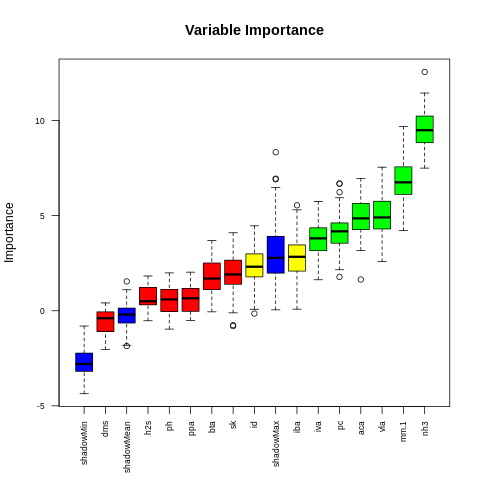

In [ ]:
%%R

plot(bo, cex.axis = .7, las = 2, xlab = "", main = "Variable Importance")

In [ ]:
%%R

odob <- cbind(log_odo["ou"], log_odo[,rownames(imps2)])
head(odob)

          ou       nh3       mm.1        aca        iba        iva        vla
1 -1.2249600 -2.043309 -0.6331603 -1.0749493 -1.7334805 -1.8596790 -1.3374486
2 -1.2249600 -1.936882  1.0552224  0.7668098  1.2984638  1.3516990  1.2950587
3 -0.8209050 -1.468885 -0.8879723  0.5917261  0.9772720  1.0695726  1.1290003
4  0.7260806 -1.416330 -0.8879723  0.4284440  0.6718374  0.8924571  0.7198563
5 -1.1919213 -1.263970 -0.8879723  0.3237269  0.5326620  0.8428153  0.6331179
6 -0.4168700 -1.458160 -0.8879723  0.2447109  0.3998548  0.6910340  0.6049416
          pc
1 -4.7612230
2  0.8397641
3  0.3658753
4  0.2936154
5  0.3888851
6  0.1798871


### **5) 다중 공선성 확인**

In [ ]:
%%R

mrr <- lm(ou ~ ., data = odor)
mrl <- lm(ou ~ ., data = odol)
mre <- lm(ou ~ ., data = odoe)
mrb <- lm(ou ~ ., data = odob)

VIFR <- vif(mrr)
VIFL <- vif(mrl)
VIFE <- vif(mre)
VIFB <- vif(mrb)

print("Ridge")
print(VIFR)
cat("\n", sum(VIFR > 10), "개 :", names(odo[VIFR > 10]), "\n\n")

print("LASSO")
print(VIFL)
cat("\n", sum(VIFL > 10), "개 :", names(odol[VIFL > 10]), "\n\n")

print("Elastic Net")
print(VIFE)
cat("\n", sum(VIFE > 10), "개 :", names(odo[VIFE > 10]), "\n\n")

print("Boruta")
print(VIFB)
cat("\n", sum(VIFB > 10), "개 :", names(odo[VIFB > 10]))

[1] "Ridge"
     h2s     mm.1      aca      vla       ph       sk 
1.089726 1.203702 1.991926 4.509083 3.081783 2.868197 

 0 개 :  

[1] "LASSO"
     h2s     mm.1      aca      vla       sk 
1.084803 1.124732 1.795773 2.730420 2.783607 

 0 개 :  

[1] "Elastic Net"
      nh3       h2s      mm.1       aca       ppa       bta       iva       vla 
 1.677661  1.350663  1.806161  2.111951 16.888811 28.476078 28.617301 13.341476 
       sk 
 2.990668 

 4 개 : dms aca ppa iba id sk 

[1] "Boruta"
      nh3      mm.1       aca       iba       iva       vla        pc 
 1.887289  1.276593  2.029489 12.827293 37.043009 15.380176  5.611145 

 3 개 : mm.1 dms aca vla ph pc

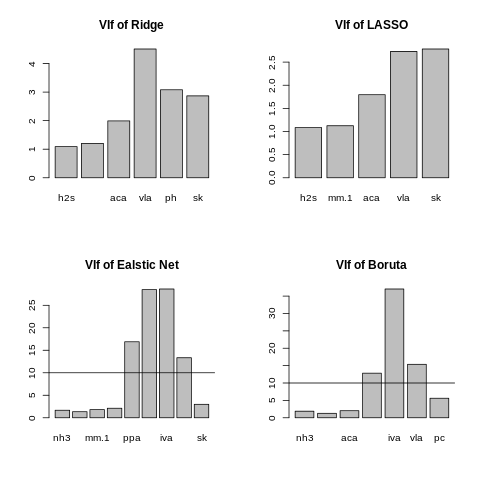

In [ ]:
%%R

par(mfrow = c(2,2))
barplot(VIFR, main = "VIf of Ridge") ; abline(h = 10)
barplot(VIFL, main = "VIf of LASSO") ; abline(h = 10)
barplot(VIFE, main = "VIf of Ealstic Net") ; abline(h = 10)
barplot(VIFB, main = "VIf of Boruta") ; abline(h = 10)
par(mfrow = c(1,1))

## **3. Log + PLS**

### **1) Model (pr, prr, prl,pre, prb)**

In [ ]:
%%R

### Validation method : Leave-One-Out

pr <- plsr(ou ~ ., data = log_odo, ncomp = ncol(log_odo)-1, validation = "LOO")         # 기본
prr <- plsr(ou ~ ., data = odor, ncomp = ncol(odor)-1, validation = "LOO")      # Ridge
prl <- plsr(ou ~ ., data = odol, ncomp = ncol(odol)-1, validation = "LOO")      # LASSO
pre <- plsr(ou ~ ., data = odoe, ncomp = ncol(odoe)-1, validation = "LOO")      # Elastic net
prb <- plsr(ou ~ ., data = odob, ncomp = ncol(odob)-1, validation = "LOO")      # Boruta

### **2) Optimal Components**

Basic :  4 
Ridge :  6 
LASSO :  3 
Elastic net :  2 
Boruta :  5

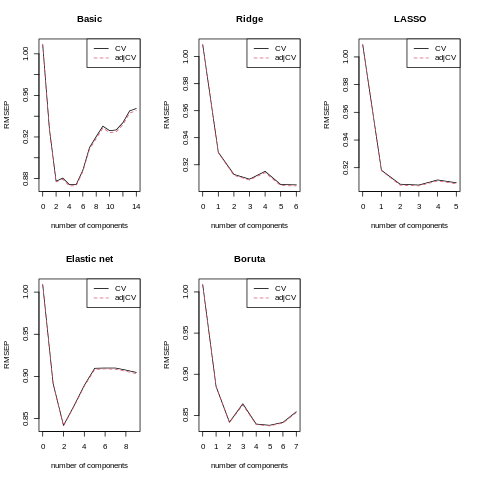

In [ ]:
%%R

par(mfrow = c(2,3))
plot(RMSEP(pr), legendpos = "topright", main = "Basic")
plot(RMSEP(prr), legendpos = "topright", main = "Ridge")
plot(RMSEP(prl), legendpos = "topright", main = "LASSO")
plot(RMSEP(pre), legendpos = "topright", main = "Elastic net")
plot(RMSEP(prb), legendpos = "topright", main = "Boruta")
par(mfrow = c(1,1))

# 최적의 ncomp 수 

ocom = which.min(pr$validation$PRESS)
ocomr = which.min(prr$validation$PRESS)
ocoml = which.min(prl$validation$PRESS)
ocome = which.min(pre$validation$PRESS)
ocomb = which.min(prb$validation$PRESS)

cat("Basic : ", ocom, "\n")
cat("Ridge : ", ocomr, "\n")
cat("LASSO : ", ocoml, "\n")
cat("Elastic net : ", ocome, "\n")
cat("Boruta : ", ocomb)

### **3) Loading Value**

#### **- Original**

In [ ]:
%%R

print(pr$loadings[ , 1:ocom])

print(pr$Yloadings[ , 1:ocom])

         Comp 1      Comp 2      Comp 3      Comp 4
nh3  0.16696939  0.52033292  0.12212920 -0.31265397
h2s  0.03917450  0.03435580  0.61278994 -0.68603662
mm.1 0.09930428  0.55154203 -0.22490463  0.40222891
dms  0.05389278  0.09996739 -0.61872429  0.55148810
aca  0.33388006 -0.07403241 -0.10358288  0.02118663
ppa  0.35854494 -0.29204371  0.07343114  0.05629571
iba  0.39018429 -0.27357152 -0.01892080 -0.06103357
bta  0.34863527 -0.36883306  0.15951153  0.01145184
iva  0.37723377 -0.29969077  0.19255949  0.06854951
vla  0.36243531 -0.26526770  0.29616112  0.15347222
ph   0.36022989 -0.12435814 -0.22635529 -0.06010365
pc   0.36869920 -0.10661806 -0.05787640 -0.26384851
id   0.32896730  0.01874009 -0.51724707 -0.23992170
sk   0.31276426 -0.14545515  0.20579539  0.37841062
   Comp 1    Comp 2    Comp 3    Comp 4 
0.1929257 0.2948347 0.3271244 0.1104758 


#### **- Ridge**

In [ ]:
%%R

print(prr$loadings[ , 1:ocomr])

print(prr$Yloadings[ , 1:ocomr])

         Comp 1     Comp 2      Comp 3      Comp 4      Comp 5      Comp 6
h2s  0.02090923  0.1199073  1.12349785 -0.78599030  0.06238607 -0.10026602
mm.1 0.27040964  0.8348399 -0.45156551  0.14566573  0.06676715 -0.08593483
aca  0.50684177 -0.2175969  0.15495152  0.03723989 -0.06687290  0.86397693
vla  0.52352115 -0.4247992  0.23366923  0.40273516  0.22349324 -0.37996468
ph   0.52661321 -0.3094560 -0.17097552 -0.54022102  0.58278543 -0.13135902
sk   0.52937935 -0.2554165 -0.02306951  0.06010332 -0.77330348 -0.27290555
     Comp 1      Comp 2      Comp 3      Comp 4      Comp 5      Comp 6 
0.288760691 0.288093890 0.139270888 0.243948236 0.056389486 0.001017299 


#### **- LASSO**

In [ ]:
%%R

print(prl$loadings[ , 1:ocoml])

print(prl$Yloadings[ , 1:ocoml])

         Comp 1     Comp 2      Comp 3
h2s  0.02780571  0.1541173  1.00505989
mm.1 0.34305496  0.7916847 -0.41579641
aca  0.57142940 -0.2882312  0.09380191
vla  0.56442115 -0.4434699  0.26936129
sk   0.60921414 -0.3740725 -0.14927389
    Comp 1     Comp 2     Comp 3 
0.34817942 0.24220946 0.07748915 


#### **- Elastic net**

In [ ]:
%%R

print(pre$loadings[ , 1:ocome])

print(pre$Yloadings[ , 1:ocome])

         Comp 1      Comp 2
nh3  0.24903971  0.48617842
h2s  0.05769541  0.03301376
mm.1 0.18069831  0.48865783
aca  0.43458511 -0.12357850
ppa  0.45199846 -0.32161541
bta  0.43467058 -0.39495659
iva  0.48104103 -0.34101376
vla  0.47251179 -0.31238714
sk   0.42780928 -0.21648969
   Comp 1    Comp 2 
0.2970600 0.2358941 


#### **- Boruta**

In [ ]:
%%R

print(prb$loadings[ , 1:ocomb])

print(prb$Yloadings[ , 1:ocomb])

        Comp 1     Comp 2      Comp 3       Comp 4      Comp 5
nh3  0.3140163  0.4623001 -0.17757302  0.757971833 -0.51889525
mm.1 0.2151457  0.5324227  0.05663242 -0.821619086  0.31386439
aca  0.4421668 -0.1994222  0.03809575 -0.004072951  0.70083160
iba  0.4841100 -0.3808616 -0.09929391 -0.041752855 -0.64595774
iva  0.4658160 -0.4170764  0.26339611 -0.147209532 -0.07658200
vla  0.4479689 -0.3745294  0.72924901 -0.139403090  0.01390681
pc   0.5007724 -0.2361507 -0.74799227  0.183290910  0.25498285
   Comp 1    Comp 2    Comp 3    Comp 4    Comp 5 
0.3086312 0.2269049 0.4273689 0.0959233 0.1875091 


### **4) New Data Set**

In [ ]:
%%R

# New Original
om <- matrix(as.numeric(pr$scores), ncol = ncol(log_odo)-1)
new_odo <- cbind(log_odo["ou"], om)
colnames(new_odo) <- c("ou",colnames(pr$scores))

# New Ridge
orm <- matrix(as.numeric(prr$scores), ncol = ncol(odor)-1)
new_odor <- cbind(odor["ou"], orm)
colnames(new_odor) <- c("ou",colnames(prr$scores))

# New LASSO
olm <- matrix(as.numeric(prl$scores), ncol = ncol(odol)-1)
new_odol <- cbind(odol["ou"], olm)
colnames(new_odol) <- c("ou",colnames(prl$scores))

# New Elastic Net
oem <- matrix(as.numeric(pre$scores), ncol = ncol(odoe)-1)
new_odoe <- cbind(odoe["ou"], oem)
colnames(new_odoe) <- c("ou",colnames(pre$scores))

# New boruta
obm <- matrix(as.numeric(prb$scores), ncol = ncol(odob)-1)
new_odob <- cbind(odob["ou"], obm)
colnames(new_odob) <- c("ou",colnames(prb$scores))

### **5) Correlation Plot**

#### **- Original**

**- Correlation Plot (hitmap)**

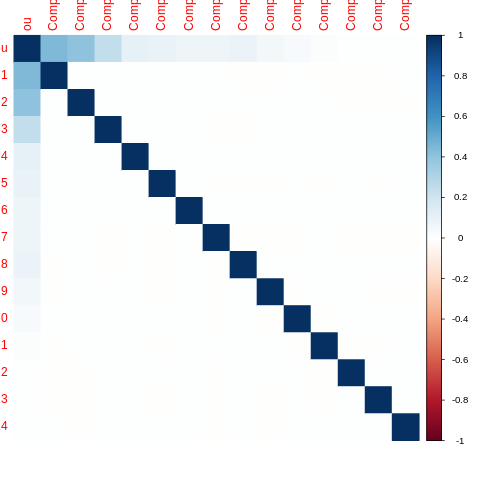

In [ ]:
%%R

reso <- cor(new_odo, method = "pearson")
corrplot::corrplot(reso, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

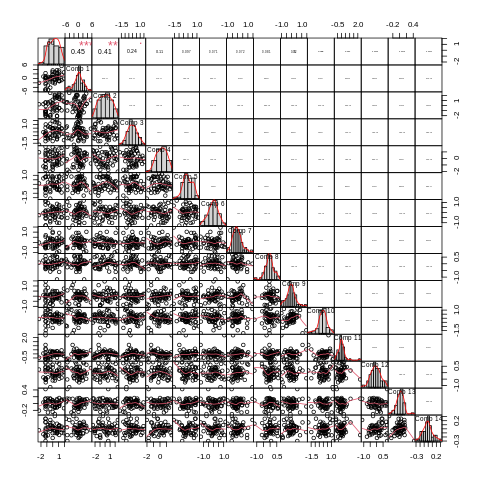

In [ ]:
%%R

chart.Correlation(new_odo, histogram = T, pch = 5)

In [ ]:
%%R

# 반응변수
print(round(reso["ou",],3))

# Total
# print(reso)

     ou  Comp 1  Comp 2  Comp 3  Comp 4  Comp 5  Comp 6  Comp 7  Comp 8  Comp 9 
  1.000   0.447   0.409   0.240   0.108   0.097   0.071   0.072   0.081   0.052 
Comp 10 Comp 11 Comp 12 Comp 13 Comp 14 
  0.036   0.014   0.004   0.005   0.002 


#### **- Ridge**

**- Correlation Plot (hitmap)**

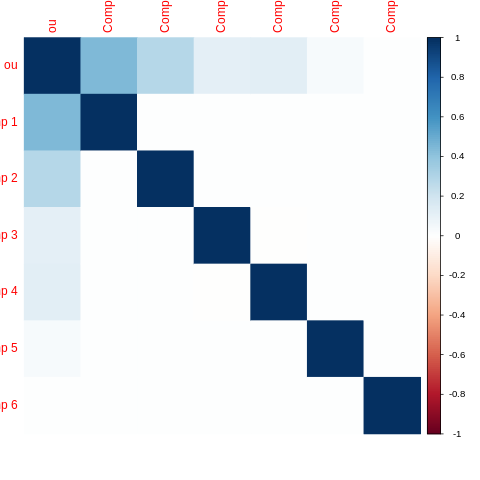

In [ ]:
%%R

resr <- cor(new_odor, method = "pearson")
corrplot::corrplot(resr, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

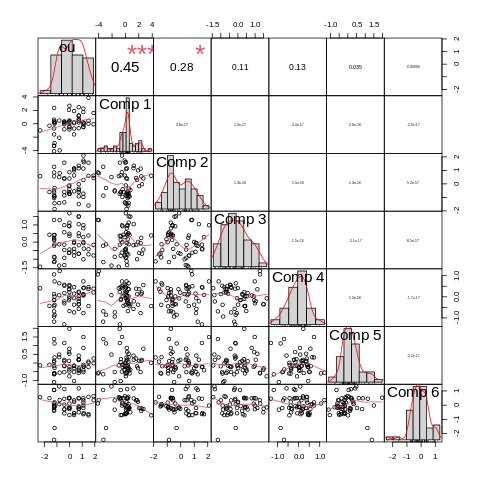

In [ ]:
%%R

chart.Correlation(new_odor, histogram = T, pch = 5)

In [ ]:
%%R

# 반응변수
print(round(resr["ou",],3))

# Total
# print(resr)

    ou Comp 1 Comp 2 Comp 3 Comp 4 Comp 5 Comp 6 
 1.000  0.450  0.285  0.111  0.128  0.035  0.001 


#### **- LASSO**

**- Correlation Plot (hitmap)**

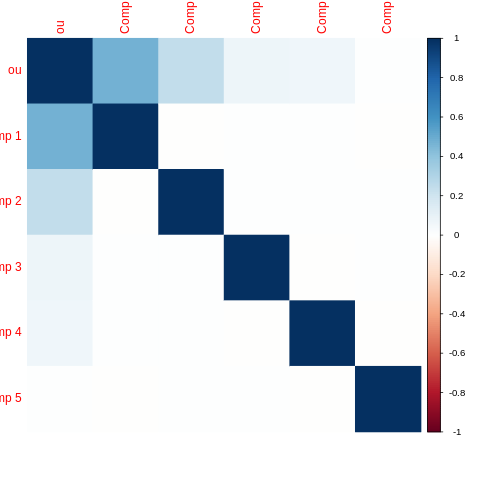

In [ ]:
%%R

resl <- cor(new_odol, method = "pearson")
corrplot::corrplot(resl, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

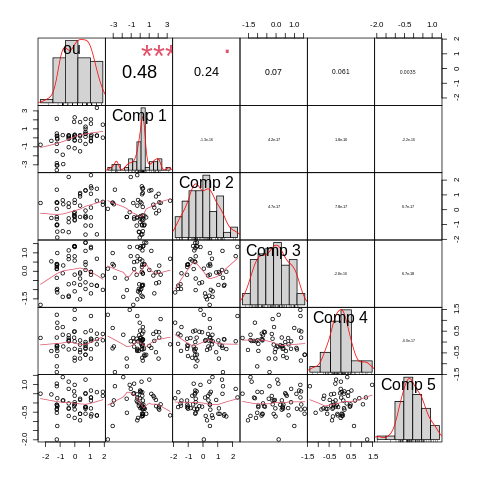

In [ ]:
%%R

chart.Correlation(new_odol, histogram = T, pch = 5)

In [ ]:
%%R

# 반응변수
print(round(resl["ou",],4))

# Total
# print(resl)

    ou Comp 1 Comp 2 Comp 3 Comp 4 Comp 5 
1.0000 0.4782 0.2416 0.0703 0.0606 0.0035 


#### **- Elastic Net**

**- Correlation Plot (hitmap)**

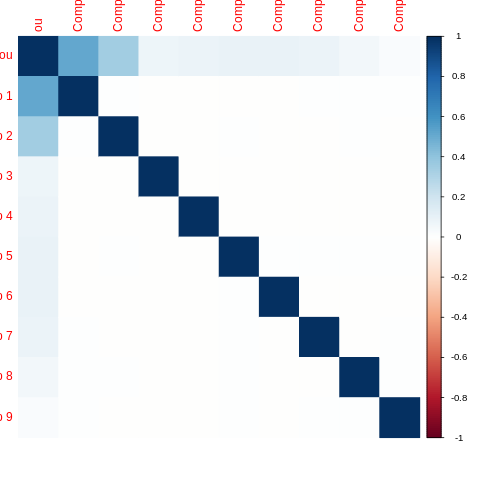

In [ ]:
%%R

rese <- cor(new_odoe, method = "pearson")
corrplot::corrplot(rese, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

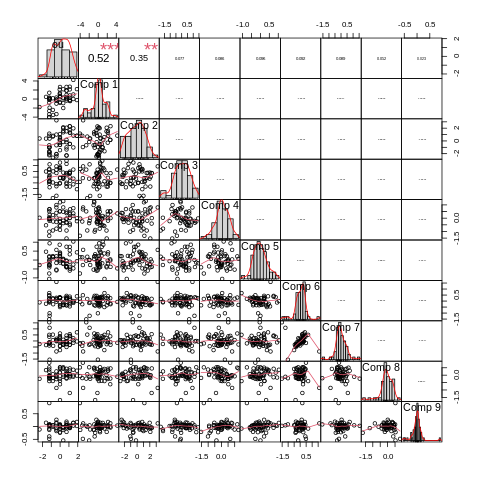

In [ ]:
%%R

chart.Correlation(new_odoe, histogram = T, pch = 5)

In [ ]:
%%R

# 반응변수
print(round(rese["ou",], 3))

# Total
# print(rese)

    ou Comp 1 Comp 2 Comp 3 Comp 4 Comp 5 Comp 6 Comp 7 Comp 8 Comp 9 
 1.000  0.518  0.346  0.077  0.086  0.096  0.092  0.089  0.052  0.023 


#### **- Boruta**

**- Correlation Plot (hitmap)**

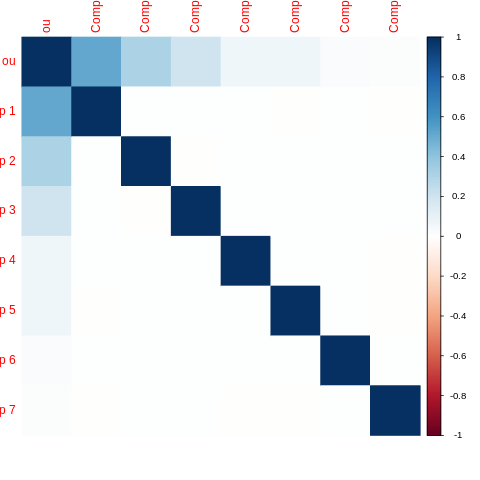

In [ ]:
%%R

resb <- cor(new_odob, method = "pearson")
corrplot::corrplot(resb, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

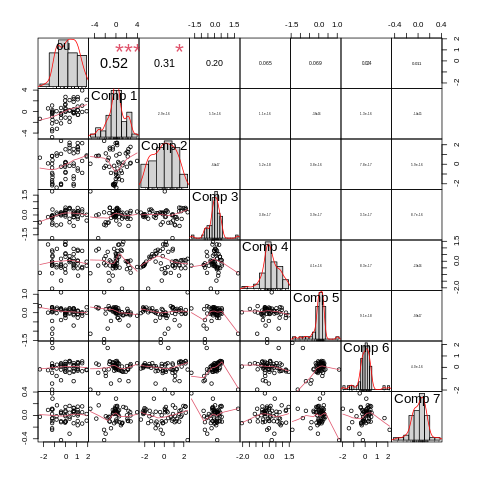

In [ ]:
%%R

chart.Correlation(new_odob, histogram = T, pch = 5)

In [ ]:
%%R

# 반응변수
print(round(resb["ou",], 3))

# Total
# print(resb)

    ou Comp 1 Comp 2 Comp 3 Comp 4 Comp 5 Comp 6 Comp 7 
 1.000  0.519  0.313  0.205  0.065  0.069  0.024  0.011 


#### **TOTAL**

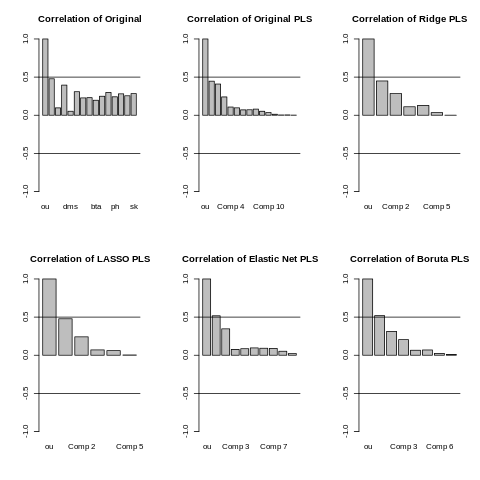

In [ ]:
%%R

par(mfrow = c(2,3))
barplot(res["ou",], ylim = c(-1,1), main = "Correlation of Original") ; abline(h = c(-0.5, 0.5))
barplot(reso["ou",], ylim = c(-1,1), main = "Correlation of Original PLS") ; abline(h = c(-0.5, 0.5))
barplot(resr["ou",], ylim = c(-1,1), main = "Correlation of Ridge PLS") ; abline(h = c(-0.5, 0.5))
barplot(resl["ou",], ylim = c(-1,1), main = "Correlation of LASSO PLS") ; abline(h = c(-0.5, 0.5))
barplot(rese["ou",], ylim = c(-1,1), main = "Correlation of Elastic Net PLS") ; abline(h = c(-0.5, 0.5))
barplot(resb["ou",], ylim = c(-1,1), main = "Correlation of Boruta PLS") ; abline(h = c(-0.5, 0.5))
par(mfrow = c(1,1))

### **6) Plots**

#### **- VIP**

In [ ]:
%%R

vip <- round(VIP(pr, opt.comp = ocom), 3)
vipr <- round(VIP(prr, opt.comp = ocomr), 3)
vipl <- round(VIP(prl, opt.comp = ocoml), 3)
vipe <- round(VIP(pre, opt.comp = ocome), 3)
vipb <- round(VIP(prb, opt.comp = ocomb), 3)

print("VIP - Basic")
print(sort(vip, decreasing = T))
cat("\n")

print("VIP - Ridge")
print(sort(vipr, decreasing = T))
cat("\n")

print("VIP - LASSO")
print(sort(vipl, decreasing = T))
cat("\n")

print("VIP - Elastic Net")
print(sort(vipe, decreasing = T))
cat("\n")

print("VIP - Boruta")
print(sort(vipb, decreasing = T))

[1] "VIP - Basic"
  nh3  mm.1    id   vla    ph   iba   bta    pc   iva   ppa    sk   aca   h2s 
1.713 1.548 1.027 0.991 0.931 0.919 0.902 0.875 0.868 0.828 0.787 0.782 0.600 
  dms 
0.559 

[1] "VIP - Ridge"
 mm.1   vla    ph    sk   aca   h2s 
1.450 0.974 0.933 0.902 0.895 0.679 

[1] "VIP - LASSO"
 mm.1    sk   aca   vla   h2s 
1.388 0.989 0.970 0.963 0.476 

[1] "VIP - Elastic Net"
  nh3  mm.1   vla   iva   aca   ppa    sk   bta   h2s 
1.564 1.334 0.926 0.917 0.896 0.863 0.853 0.840 0.305 

[1] "VIP - Boruta"
  nh3  mm.1   vla    pc   iba   aca   iva 
1.324 1.172 0.976 0.963 0.864 0.790 0.789 


In [ ]:
%%R

cat("중요한 변수 - Basic : ",  names(vip[which(vip >= 1)]), "(", sum(vip >= 1),"개", ")", "\n")
cat("중요한 변수 - Ridge : ",  names(vipr[which(vipr >= 1)]), "(", sum(vipr >= 1),"개", ")", "\n")
cat("중요한 변수 - LASSO : ",  names(vipl[which(vipl >= 1)]), "(", sum(vipl >= 1),"개", ")", "\n")
cat("중요한 변수 - Elastic Net : ",  names(vipe[which(vipe >= 1)]), "(", sum(vipe >= 1),"개", ")", "\n")
cat("중요한 변수 - Boruta : ",  names(vipb[which(vipb >= 1)]), "(", sum(vipb >= 1),"개", ")")

중요한 변수 - Basic :  nh3 mm.1 id ( 3 개 ) 
중요한 변수 - Ridge :  mm.1 ( 1 개 ) 
중요한 변수 - LASSO :  mm.1 ( 1 개 ) 
중요한 변수 - Elastic Net :  nh3 mm.1 ( 2 개 ) 
중요한 변수 - Boruta :  nh3 mm.1 ( 2 개 )

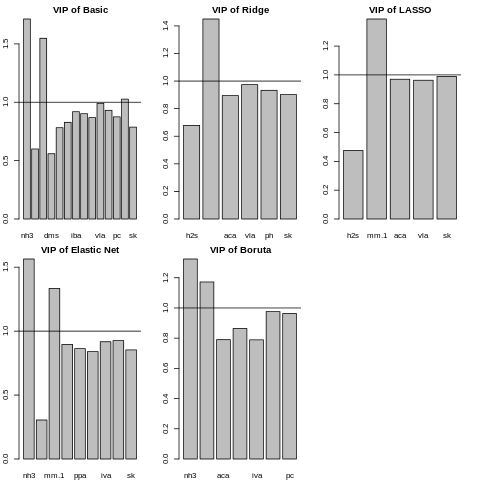

In [ ]:
%%R

par(mfrow = c(2,3), mar = c(2,2,2,2))   # mar : plot inner margin
barplot(vip, main = "VIP of Basic") ; abline(h = 1)
barplot(vipr, main = "VIP of Ridge") ; abline(h = 1)
barplot(vipl, main = "VIP of LASSO") ; abline(h = 1)
barplot(vipe, main = "VIP of Elastic Net") ; abline(h = 1)
barplot(vipb, main = "VIP of Boruta") ; abline(h = 1)
par(mfrow = c(1,1))

#### **- Biplot**

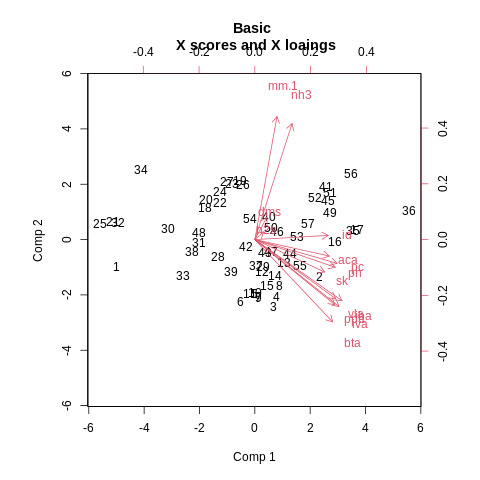

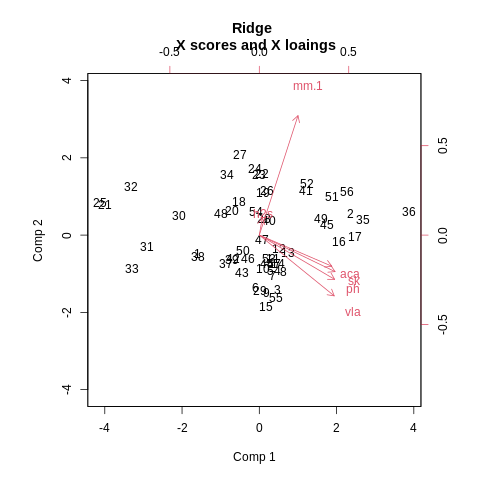

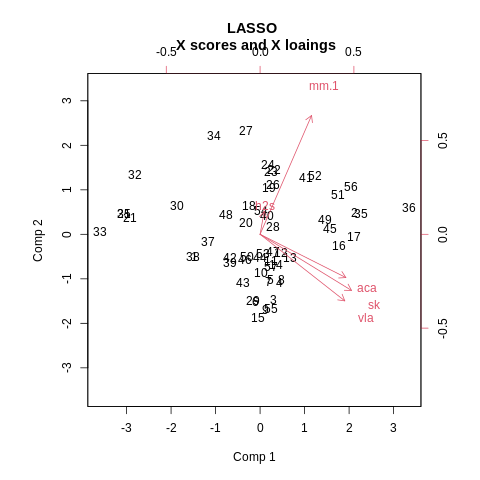

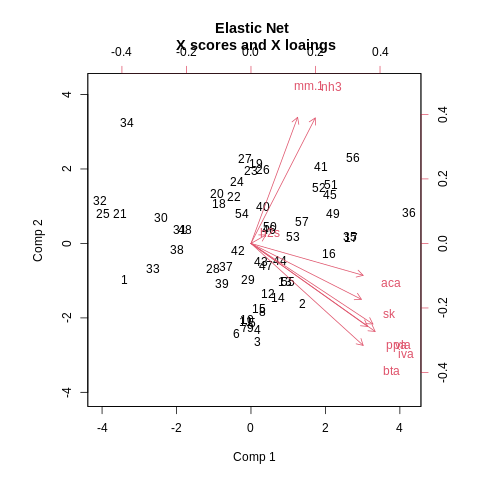

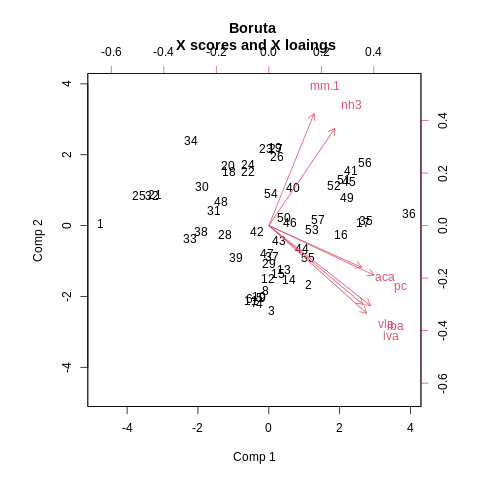

In [ ]:
%%R

biplot(pr, var.axes = T, main = "Basic \n X scores and X loaings")
biplot(prr, var.axes = T, main = "Ridge \n X scores and X loaings")
biplot(prl, var.axes = T, main = "LASSO \n X scores and X loaings")
biplot(pre, var.axes = T, main = "Elastic Net \n X scores and X loaings")
biplot(prb, var.axes = T, main = "Boruta \n X scores and X loaings")

## **4. ALL PLS + Regression**

- All components

- "lm" function in R


### **1) Original PLSR (prm)**

In [ ]:
%%R

prm <- lm(ou ~ ., data = new_odo)
print(summary(prm))
cat("최적 components 수 :", ocom)


Call:
lm(formula = ou ~ ., data = new_odo)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.82846 -0.45261  0.00082  0.43087  1.90520 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.573e-16  1.117e-01   0.000 1.000000    
`Comp 1`     1.929e-01  4.864e-02   3.966 0.000279 ***
`Comp 2`     2.948e-01  8.116e-02   3.633 0.000757 ***
`Comp 3`     3.271e-01  1.535e-01   2.132 0.038926 *  
`Comp 4`     1.105e-01  1.155e-01   0.956 0.344424    
`Comp 5`     1.529e-01  1.775e-01   0.862 0.393839    
`Comp 6`     1.242e-01  1.985e-01   0.626 0.534793    
`Comp 7`     1.540e-01  2.417e-01   0.637 0.527325    
`Comp 8`     2.458e-01  3.427e-01   0.717 0.477219    
`Comp 9`     1.124e-01  2.433e-01   0.462 0.646286    
`Comp 10`    6.015e-02  1.897e-01   0.317 0.752763    
`Comp 11`    2.929e-02  2.435e-01   0.120 0.904842    
`Comp 12`    8.521e-03  2.694e-01   0.032 0.974913    
`Comp 13`    3.626e-02  9.059e-01   0.040 0.968262    
`Comp 14`   

### **2) Ridge PLSR (prrm)**



In [ ]:
%%R

prrm <- lm(ou ~ ., data = new_odor)
print(summary(prrm))
cat("최적 components 수 :", ocomr)


Call:
lm(formula = ou ~ ., data = new_odor)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14188 -0.39604 -0.07592  0.54846  1.83933 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.724e-16  1.162e-01   0.000 1.000000    
`Comp 1`     2.888e-01  7.528e-02   3.836 0.000352 ***
`Comp 2`     2.881e-01  1.185e-01   2.431 0.018679 *  
`Comp 3`     1.393e-01  1.465e-01   0.951 0.346241    
`Comp 4`     2.439e-01  2.227e-01   1.096 0.278482    
`Comp 5`     5.639e-02  1.913e-01   0.295 0.769400    
`Comp 6`     1.017e-03  1.808e-01   0.006 0.995532    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.877 on 50 degrees of freedom
Multiple R-squared:  0.3133,	Adjusted R-squared:  0.2309 
F-statistic: 3.803 on 6 and 50 DF,  p-value: 0.003377

최적 components 수 : 6

### **3) LASSO PLSR (prlm)**

In [ ]:
%%R

prlm <- lm(ou ~ ., data = new_odol)
print(summary(prlm))
cat("최적 components 수 :", ocoml)


Call:
lm(formula = ou ~ ., data = new_odol)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.12866 -0.46073 -0.00215  0.56434  1.83579 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.853e-16  1.165e-01   0.000 1.000000    
`Comp 1`     3.482e-01  8.557e-02   4.069 0.000164 ***
`Comp 2`     2.422e-01  1.178e-01   2.056 0.044922 *  
`Comp 3`     7.749e-02  1.295e-01   0.599 0.552116    
`Comp 4`     1.074e-01  2.083e-01   0.516 0.608269    
`Comp 5`     5.486e-03  1.824e-01   0.030 0.976123    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8794 on 51 degrees of freedom
Multiple R-squared:  0.2957,	Adjusted R-squared:  0.2266 
F-statistic: 4.282 on 5 and 51 DF,  p-value: 0.002507

최적 components 수 : 3

### **4) Elastic Net PLSR (prem)**

In [ ]:
%%R

prem <- lm(ou ~ ., data = new_odoe)
print(summary(prem))
cat("최적 components 수 :", ocome)


Call:
lm(formula = ou ~ ., data = new_odoe)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8482 -0.5152 -0.1031  0.5239  1.9440 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.003e-16  1.092e-01   0.000  1.00000    
`Comp 1`     2.971e-01  6.323e-02   4.698 2.31e-05 ***
`Comp 2`     2.359e-01  7.504e-02   3.144  0.00289 ** 
`Comp 3`     1.070e-01  1.537e-01   0.696  0.48985    
`Comp 4`     1.437e-01  1.851e-01   0.777  0.44128    
`Comp 5`     2.246e-01  2.577e-01   0.871  0.38792    
`Comp 6`     2.031e-01  2.436e-01   0.834  0.40872    
`Comp 7`     1.921e-01  2.366e-01   0.812  0.42090    
`Comp 8`     1.235e-01  2.600e-01   0.475  0.63705    
`Comp 9`     1.169e-01  5.669e-01   0.206  0.83753    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8243 on 47 degrees of freedom
Multiple R-squared:  0.4298,	Adjusted R-squared:  0.3206 
F-statistic: 3.936 on 9 and 47 DF,  p-value: 0.0008694

최적

### **5) Boruta PLSR (prbm)**

In [ ]:
%%R

prbm <- lm(ou ~ ., data = new_odob)
print(summary(prbm))
cat("최적 components 수 :", ocomb)


Call:
lm(formula = ou ~ ., data = new_odob)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84670 -0.49508 -0.01129  0.32653  1.84754 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.094e-16  1.079e-01   0.000  1.00000    
`Comp 1`     3.086e-01  6.467e-02   4.772 1.68e-05 ***
`Comp 2`     2.269e-01  7.896e-02   2.873  0.00599 ** 
`Comp 3`     4.274e-01  2.269e-01   1.883  0.06560 .  
`Comp 4`     9.592e-02  1.594e-01   0.602  0.55020    
`Comp 5`     1.875e-01  2.950e-01   0.636  0.52799    
`Comp 6`     3.985e-02  1.772e-01   0.225  0.82297    
`Comp 7`     8.283e-02  7.905e-01   0.105  0.91698    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8145 on 49 degrees of freedom
Multiple R-squared:  0.4195,	Adjusted R-squared:  0.3365 
F-statistic: 5.058 on 7 and 49 DF,  p-value: 0.0002269

최적 components 수 : 5

### **6) 잔차 검정**

- 전부 등분산성과  독립성은 만족

- But 전부 정규성을 만족하지 못한다.

In [ ]:
%%R

# par(mfrow=c(2,2))
# plot(prm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prrm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prlm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prem)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prbm)
# par(mfrow=c(1,1))

NULL


##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [ ]:
%%R

print(bptest(prm))
print(bptest(prrm))
print(bptest(prlm))
print(bptest(prem))
print(bptest(prbm))


	studentized Breusch-Pagan test

data:  prm
BP = 15.144, df = 14, p-value = 0.3684


	studentized Breusch-Pagan test

data:  prrm
BP = 7.724, df = 6, p-value = 0.259


	studentized Breusch-Pagan test

data:  prlm
BP = 7.3006, df = 5, p-value = 0.1992


	studentized Breusch-Pagan test

data:  prem
BP = 4.7206, df = 9, p-value = 0.858


	studentized Breusch-Pagan test

data:  prbm
BP = 4.412, df = 7, p-value = 0.7313



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

print(dwtest(prm))
print(dwtest(prrm))
print(dwtest(prlm))
print(dwtest(prem))
print(dwtest(prbm))


	Durbin-Watson test

data:  prm
DW = 1.8273, p-value = 0.1363
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prrm
DW = 1.6752, p-value = 0.07483
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prlm
DW = 1.6057, p-value = 0.04985
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prem
DW = 1.7231, p-value = 0.09724
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prbm
DW = 1.8738, p-value = 0.2186
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

prm_res <- residuals(prm)
print(shapiro.test(prm_res))

prrm_res <- residuals(prrm)
print(shapiro.test(prrm_res))

prlm_res <- residuals(prlm)
print(shapiro.test(prlm_res))

prem_res <- residuals(prem)
print(shapiro.test(prem_res))

prbm_res <- residuals(prbm)
print(shapiro.test(prbm_res))


	Shapiro-Wilk normality test

data:  prm_res
W = 0.98145, p-value = 0.5282


	Shapiro-Wilk normality test

data:  prrm_res
W = 0.98084, p-value = 0.5003


	Shapiro-Wilk normality test

data:  prlm_res
W = 0.98122, p-value = 0.5176


	Shapiro-Wilk normality test

data:  prem_res
W = 0.98536, p-value = 0.7186


	Shapiro-Wilk normality test

data:  prbm_res
W = 0.9757, p-value = 0.3051



## **5. BestPLS + Regression**

- Best Components

- "lm" function in R

### **1) Original PLSR (bprm)**

In [ ]:
%%R

bprm <- lm(ou ~ ., data = new_odo[,1:(ocom+1)])
print(summary(bprm))
cat("최적 components 수 :", ocom)


Call:
lm(formula = ou ~ ., data = new_odo[, 1:(ocom + 1)])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69110 -0.50888 -0.07488  0.44542  2.01585 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.725e-16  1.032e-01   0.000  1.00000    
`Comp 1`     1.929e-01  4.494e-02   4.293 7.71e-05 ***
`Comp 2`     2.948e-01  7.498e-02   3.932  0.00025 ***
`Comp 3`     3.271e-01  1.418e-01   2.307  0.02505 *  
`Comp 4`     1.105e-01  1.067e-01   1.035  0.30545    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.779 on 52 degrees of freedom
Multiple R-squared:  0.4365,	Adjusted R-squared:  0.3932 
F-statistic: 10.07 on 4 and 52 DF,  p-value: 4.113e-06

최적 components 수 : 4

### **2) Ridge PLSR (bprrm)**



In [ ]:
%%R

bprrm <- lm(ou ~ ., data = new_odor[, 1:(ocomr+1)])
print(summary(bprrm))
cat("최적 components 수 :", ocomr)


Call:
lm(formula = ou ~ ., data = new_odor[, 1:(ocomr + 1)])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14188 -0.39604 -0.07592  0.54846  1.83933 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.724e-16  1.162e-01   0.000 1.000000    
`Comp 1`     2.888e-01  7.528e-02   3.836 0.000352 ***
`Comp 2`     2.881e-01  1.185e-01   2.431 0.018679 *  
`Comp 3`     1.393e-01  1.465e-01   0.951 0.346241    
`Comp 4`     2.439e-01  2.227e-01   1.096 0.278482    
`Comp 5`     5.639e-02  1.913e-01   0.295 0.769400    
`Comp 6`     1.017e-03  1.808e-01   0.006 0.995532    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.877 on 50 degrees of freedom
Multiple R-squared:  0.3133,	Adjusted R-squared:  0.2309 
F-statistic: 3.803 on 6 and 50 DF,  p-value: 0.003377

최적 components 수 : 6

### **3) LASSO PLSR (bprlm)**

In [ ]:
%%R

bprlm <- lm(ou ~ ., data = new_odol[, 1:(ocoml+1)])
print(summary(bprlm))
cat("최적 components 수 :", ocoml)


Call:
lm(formula = ou ~ ., data = new_odol[, 1:(ocoml + 1)])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.10842 -0.51242 -0.00302  0.53749  1.88034 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.920e-16  1.146e-01   0.000 1.000000    
`Comp 1`     3.482e-01  8.416e-02   4.137 0.000126 ***
`Comp 2`     2.422e-01  1.159e-01   2.090 0.041393 *  
`Comp 3`     7.749e-02  1.273e-01   0.609 0.545394    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8649 on 53 degrees of freedom
Multiple R-squared:  0.292,	Adjusted R-squared:  0.2519 
F-statistic: 7.285 on 3 and 53 DF,  p-value: 0.0003525

최적 components 수 : 3

### **4) Elastic Net PLSR (bprem)**

In [ ]:
%%R

bprem <- lm(ou ~ ., data = new_odoe[, 1:(ocome+1)])
print(summary(bprem))
cat("최적 components 수 :", ocome)


Call:
lm(formula = ou ~ ., data = new_odoe[, 1:(ocome + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8948 -0.5575 -0.1089  0.6079  1.7805 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.082e-16  1.055e-01   0.000  1.00000    
`Comp 1`     2.971e-01  6.113e-02   4.860 1.05e-05 ***
`Comp 2`     2.359e-01  7.255e-02   3.252  0.00198 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7969 on 54 degrees of freedom
Multiple R-squared:  0.3877,	Adjusted R-squared:  0.365 
F-statistic:  17.1 on 2 and 54 DF,  p-value: 1.771e-06

최적 components 수 : 2

### **5) Boruta PLSR (bprbm)**

In [ ]:
%%R

bprbm <- lm(ou ~ ., data = new_odob[, 1:(ocomb+1)])
print(summary(bprbm))
cat("최적 components 수 :", ocomb)


Call:
lm(formula = ou ~ ., data = new_odob[, 1:(ocomb + 1)])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84905 -0.50544 -0.00957  0.33862  1.83994 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.076e-16  1.058e-01   0.000  1.00000    
`Comp 1`     3.086e-01  6.343e-02   4.866 1.14e-05 ***
`Comp 2`     2.269e-01  7.745e-02   2.930  0.00506 ** 
`Comp 3`     4.274e-01  2.226e-01   1.920  0.06044 .  
`Comp 4`     9.592e-02  1.564e-01   0.613  0.54234    
`Comp 5`     1.875e-01  2.893e-01   0.648  0.51986    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7989 on 51 degrees of freedom
Multiple R-squared:  0.4187,	Adjusted R-squared:  0.3617 
F-statistic: 7.348 on 5 and 51 DF,  p-value: 2.988e-05

최적 components 수 : 5

### **6) 잔차 검정**

- 전부 등분산성과  독립성은 만족

- But 전부 정규성을 만족하지 못한다.

In [ ]:
%%R

# par(mfrow=c(2,2))
# plot(bprm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprrm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprlm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprem)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprbm)
# par(mfrow=c(1,1))

NULL


##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [ ]:
%%R

print(bptest(bprm))
print(bptest(bprrm))
print(bptest(bprlm))
print(bptest(bprem))
print(bptest(bprbm))


	studentized Breusch-Pagan test

data:  bprm
BP = 7.8477, df = 4, p-value = 0.09732


	studentized Breusch-Pagan test

data:  bprrm
BP = 7.724, df = 6, p-value = 0.259


	studentized Breusch-Pagan test

data:  bprlm
BP = 5.0886, df = 3, p-value = 0.1654


	studentized Breusch-Pagan test

data:  bprem
BP = 0.73488, df = 2, p-value = 0.6925


	studentized Breusch-Pagan test

data:  bprbm
BP = 3.8018, df = 5, p-value = 0.5783



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [ ]:
%%R

print(dwtest(bprm))
print(dwtest(bprrm))
print(dwtest(bprlm))
print(dwtest(bprem))
print(dwtest(bprbm))


	Durbin-Watson test

data:  bprm
DW = 1.8201, p-value = 0.1665
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprrm
DW = 1.6752, p-value = 0.07483
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprlm
DW = 1.593, p-value = 0.04676
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprem
DW = 1.7656, p-value = 0.1506
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprbm
DW = 1.8642, p-value = 0.2233
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
%%R

bprm_res <- residuals(bprm)
print(shapiro.test(bprm_res))

bprrm_res <- residuals(bprrm)
print(shapiro.test(bprrm_res))

bprlm_res <- residuals(bprlm)
print(shapiro.test(bprlm_res))

bprem_res <- residuals(bprem)
print(shapiro.test(bprem_res))

bprbm_res <- residuals(bprbm)
print(shapiro.test(bprbm_res))


	Shapiro-Wilk normality test

data:  bprm_res
W = 0.96845, p-value = 0.1421


	Shapiro-Wilk normality test

data:  bprrm_res
W = 0.98084, p-value = 0.5003


	Shapiro-Wilk normality test

data:  bprlm_res
W = 0.98223, p-value = 0.5647


	Shapiro-Wilk normality test

data:  bprem_res
W = 0.97351, p-value = 0.2435


	Shapiro-Wilk normality test

data:  bprbm_res
W = 0.9761, p-value = 0.3176



## **6. LOOCV PLSR (Log + Best)**

### **- Model 생성**

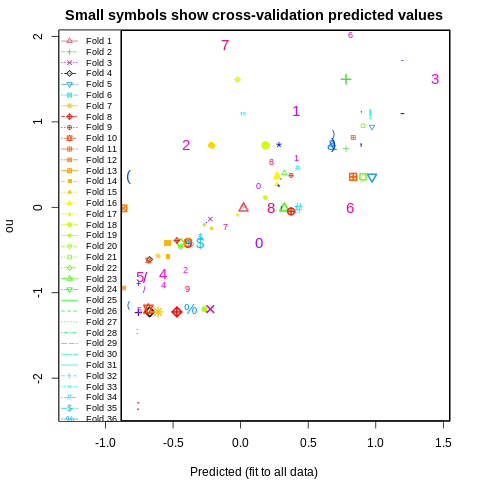

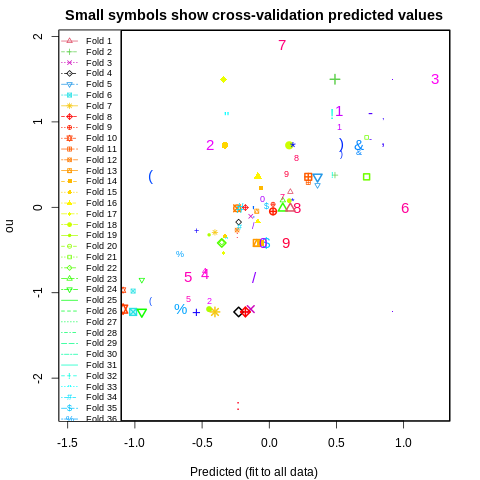

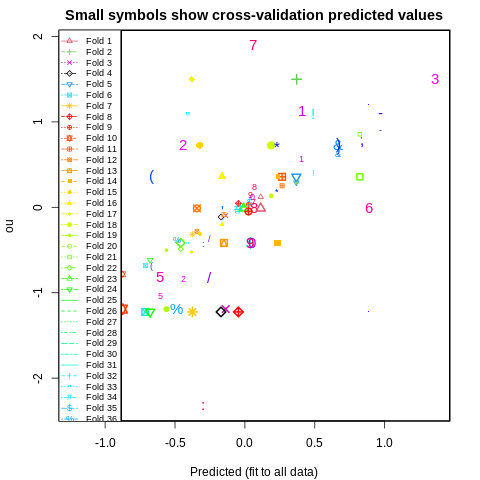

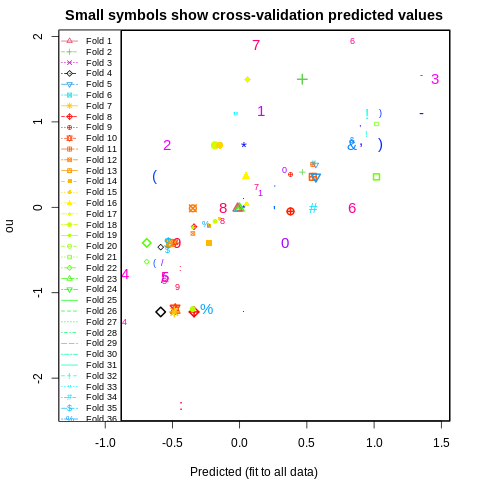

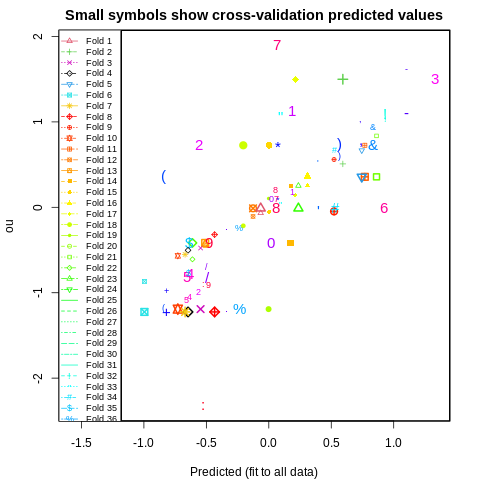

In [ ]:
%%R

cv_bprm <- cv.lm(new_odo[,1:(ocom+1)], form.lm = ou ~ ., m = nrow(new_odo), printit = F)
cv_bprrm <- cv.lm(new_odor[,1:(ocomr+1)], form.lm = ou ~ ., m = nrow(new_odor), printit = F)
cv_bprlm <- cv.lm(new_odol[,1:(ocoml+1)], form.lm = ou ~ ., m = nrow(new_odol), printit = F)
cv_bprem <- cv.lm(new_odoe[,1:(ocome+1)], form.lm = ou ~ ., m = nrow(new_odoe), printit = F)
cv_bprbm <- cv.lm(new_odob[,1:(ocomb+1)], form.lm = ou ~ ., m = nrow(new_odob), printit = F)

## **7. Results (Best comp 기준)**

### **1) Validation**

In [ ]:
%%R

### Log + Standardization Best Components
cvb_vp <- cv_bprm$cfpred
cvbr_vp <- cv_bprrm$cfpred
cvbl_vp <- cv_bprlm$cfpred
cvbe_vp <- cv_bprem$cvpred
cvbb_vp <- cv_bprbm$cvpred

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou


### Log + Best
cvb_r2 <- cor(y, cvb_vp)^2
cvbr_r2 <- cor(y, cvbr_vp)^2
cvbl_r2 <- cor(y, cvbl_vp)^2
cvbe_r2 <- cor(y, cvbe_vp)^2
cvbb_r2 <- cor(y, cvbb_vp)^2

cat("R2 - Basic : ", round(cvb_r2, 4), "\n")
cat("R2 - Ridge : ", round(cvbr_r2, 4), "\n")
cat("R2 - LASSO : ", round(cvbl_r2, 4), "\n")
cat("R2 - Elastic Net : ", round(cvbe_r2, 4), "\n")
cat("R2 - Boruta : ", round(cvbb_r2, 4))

R2 - Basic :  0.348 
R2 - Ridge :  0.157 
R2 - LASSO :  0.177 
R2 - Elastic Net :  0.307 
R2 - Boruta :  0.291

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

### Log + Best
cvb_rmse <- rmse(y, cvb_vp)^2
cvbr_rmse <- rmse(y, cvbr_vp)^2
cvbl_rmse <- rmse(y, cvbl_vp)^2
cvbe_rmse <- rmse(y, cvbe_vp)^2
cvbb_rmse <- rmse(y, cvbb_vp)^2

cat("rmse - Basic : ", round(cvb_rmse, 4), "\n")
cat("rmse - Ridge : ", round(cvbr_rmse, 4), "\n")
cat("rmse - LASSO : ", round(cvbl_rmse, 4), "\n")
cat("rmse - Elastic Net : ", round(cvbe_rmse, 4), "\n")
cat("rmse - Boruta : ", round(cvbb_rmse, 4))

rmse - Basic :  0.717 
rmse - Ridge :  0.987 
rmse - LASSO :  0.895 
rmse - Elastic Net :  0.719 
rmse - Boruta :  0.799

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

### Log + Best
cvb_mape <- mape(cvb_vp, y)^2
cvbr_mape <- mape(cvbr_vp, y)^2
cvbl_mape <- mape(cvbl_vp, y)^2
cvbe_mape <- mape(cvbe_vp, y)^2
cvbb_mape <- mape(cvbb_vp, y)^2

cat("mape - Basic : ", round(cvb_mape, 4), "\n")
cat("mape - Ridge : ", round(cvbr_mape, 4), "\n")
cat("mape - LASSO : ", round(cvbl_mape, 4), "\n")
cat("mape - Elastic Net : ", round(cvbe_mape, 4), "\n")
cat("mape - Boruta : ", round(cvbb_mape, 4))

mape - Basic :  11.7 
mape - Ridge :  119 
mape - LASSO :  12.2 
mape - Elastic Net :  32.5 
mape - Boruta :  7.82

#### **- Predplot**

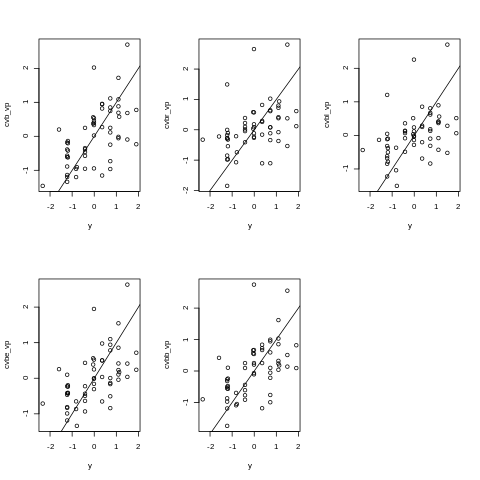

In [ ]:
%%R

par(mfrow = c(2,3))
plot(y, cvb_vp) ; abline(a = 0, b = 1)
plot(y, cvbr_vp) ; abline(a = 0, b = 1)
plot(y, cvbl_vp) ; abline(a = 0, b = 1)
plot(y, cvbe_vp) ; abline(a = 0, b = 1)
plot(y, cvbb_vp) ; abline(a = 0, b = 1)
par(mfrow = c(1,1))

### **2) Fitted**

In [ ]:
%%R

### Log + Standardization Best Components
cvb_fp <- cv_bprm$Predicted
cvbr_fp <- cv_bprrm$Predicted
cvbl_fp <- cv_bprlm$Predicted
cvbe_fp <- cv_bprem$Predicted
cvbb_fp <- cv_bprbm$Predicted

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- log_odo$ou


### Log + Best
cvb_fr2 <- cor(y, cvb_fp)^2
cvbr_fr2 <- cor(y, cvbr_fp)^2
cvbl_fr2 <- cor(y, cvbl_fp)^2
cvbe_fr2 <- cor(y, cvbe_fp)^2
cvbb_fr2 <- cor(y, cvbb_fp)^2

cat("R2 - Basic : ", round(cvb_fr2, 4), "\n")
cat("R2 - Ridge : ", round(cvbr_fr2, 4), "\n")
cat("R2 - LASSO : ", round(cvbl_fr2, 4), "\n")
cat("R2 - Elastic Net : ", round(cvbe_fr2, 4), "\n")
cat("R2 - Boruta : ", round(cvbb_fr2, 4))

R2 - Basic :  0.436 
R2 - Ridge :  0.313 
R2 - LASSO :  0.292 
R2 - Elastic Net :  0.388 
R2 - Boruta :  0.419

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

### Log + Best
cvb_frmse <- rmse(y, cvb_fp)^2
cvbr_frmse <- rmse(y, cvbr_fp)^2
cvbl_frmse <- rmse(y, cvbl_fp)^2
cvbe_frmse <- rmse(y, cvbe_fp)^2
cvbb_frmse <- rmse(y, cvbb_fp)^2

cat("rmse - Basic : ", round(cvb_frmse, 4), "\n")
cat("rmse - Ridge : ", round(cvbr_frmse, 4), "\n")
cat("rmse - LASSO : ", round(cvbl_frmse, 4), "\n")
cat("rmse - Elastic Net : ", round(cvbe_frmse, 4), "\n")
cat("rmse - Boruta : ", round(cvbb_frmse, 4))

rmse - Basic :  0.554 
rmse - Ridge :  0.675 
rmse - LASSO :  0.696 
rmse - Elastic Net :  0.602 
rmse - Boruta :  0.571

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

### Log + Best
cvb_fmape <- mape(cvb_fp, y)^2
cvbr_fmape <- mape(cvbr_fp, y)^2
cvbl_fmape <- mape(cvbl_fp, y)^2
cvbe_fmape <- mape(cvbe_fp, y)^2
cvbb_fmape <- mape(cvbb_fp, y)^2

cat("mape - Basic : ", round(cvb_fmape, 4), "\n")
cat("mape - Ridge : ", round(cvbr_fmape, 4), "\n")
cat("mape - LASSO : ", round(cvbl_fmape, 4), "\n")
cat("mape - Elastic Net : ", round(cvbe_fmape, 4), "\n")
cat("mape - Boruta : ", round(cvbb_fmape, 4))

mape - Basic :  20.9 
mape - Ridge :  13.1 
mape - LASSO :  16.2 
mape - Elastic Net :  17.7 
mape - Boruta :  366

#### **- Predplot**

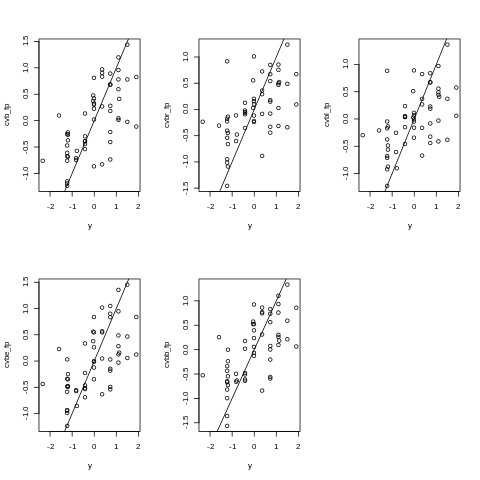

In [ ]:
%%R

par(mfrow = c(2,3))
plot(y, cvb_fp) ; abline(a = 0, b = 1)
plot(y, cvbr_fp) ; abline(a = 0, b = 1)
plot(y, cvbl_fp) ; abline(a = 0, b = 1)
plot(y, cvbe_fp) ; abline(a = 0, b = 1)
plot(y, cvbb_fp) ; abline(a = 0, b = 1)
par(mfrow = c(1,1))

### **3) 결과 정리**

In [ ]:
%%R

R2 <- c(cvb_r2, cvbr_r2, cvbl_r2, cvbe_r2, cvbb_r2)
R2 <- as.data.frame(R2)
colnames(R2) <- "R2"
rownames(R2) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

RMSE <- c(cvb_rmse, cvbr_rmse, cvbl_rmse, cvbe_rmse, cvbb_rmse)
RMSE <- as.data.frame(RMSE)
colnames(RMSE) <- "RMSE"
rownames(RMSE) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

MAPE <- c(cvb_mape, cvbr_mape, cvbl_mape, cvbe_mape, cvbb_mape)
MAPE <- as.data.frame(MAPE)
colnames(MAPE) <- "MAPE"
rownames(MAPE) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

Log_pls_valid_results <- cbind(R2, RMSE, MAPE)
Log_pls_valid_results

               R2  RMSE   MAPE
Original    0.348 0.717  11.66
Ridge       0.157 0.987 118.73
LASSO       0.177 0.895  12.20
Elastic Net 0.307 0.719  32.50
Boruta      0.291 0.799   7.82


In [ ]:
%%R

FR2 <- c(cvb_fr2, cvbr_fr2, cvbl_fr2, cvbe_fr2, cvbb_fr2)
FR2 <- as.data.frame(FR2)
colnames(FR2) <- "FR2"
rownames(FR2) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

FRMSE <- c(cvb_frmse, cvbr_frmse, cvbl_frmse, cvbe_frmse, cvbb_frmse)
FRMSE <- as.data.frame(FRMSE)
colnames(FRMSE) <- "FRMSE"
rownames(FRMSE) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

FMAPE <- c(cvb_fmape, cvbr_fmape, cvbl_fmape, cvbe_fmape, cvbb_fmape)
FMAPE <- as.data.frame(FMAPE)
colnames(FMAPE) <- "FMAPE"
rownames(FMAPE) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

Log_pls_fitted_results <- cbind(FR2, FRMSE, FMAPE)
Log_pls_fitted_results

              FR2 FRMSE FMAPE
Original    0.437 0.554  20.9
FRidge      0.313 0.675  13.1
LASSO       0.292 0.696  16.2
Elastic Net 0.388 0.602  17.7
Boruta      0.419 0.571 365.7


In [ ]:
%%R

Results <- cbind(Log_pls_valid_results, Log_pls_fitted_results)
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) Log_PLS.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) Log_PLS.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results

               R2  RMSE   MAPE   FR2 FRMSE FMAPE
Original    0.348 0.717  11.66 0.437 0.554  20.9
Ridge       0.157 0.987 118.73 0.313 0.675  13.1
LASSO       0.177 0.895  12.20 0.292 0.696  16.2
Elastic Net 0.307 0.719  32.50 0.388 0.602  17.7
Boruta      0.291 0.799   7.82 0.419 0.571 365.7
